In [1]:
function circ(x::Array{Float64, 1}, y::Array{Float64, 1}, diam::Float64, x0::Float64, y0::Float64)
    return [float((x-x0)^2 + (y-y0)^2 < (diam/2.)^2) for x in x, y in y]
end

function rect(x::Array{Float64, 1}, y::Array{Float64, 1}, Lx::Float64, Ly::Float64, x0::Float64, y0::Float64)
    return [float( abs(x-x0)<Lx/2 && abs(y-y0)<Ly/2 ) for x in x, y in y]
end

function face(x,y)
# FACE generates a face-shaped phantom

    # outline of face
    F = 0.8*circ(x, y, 20., 0., 0.); 

    # nose 
    F = F-0.4*rect(x, y, 1.5, 4., 0., 0.5); 

    # mouth
    F = F-0.4*rect(x, y, 10., 1.5, 0., 5.75); 

    # eyes
    F = F-0.4*circ(x, y, 3.5,  4., -4.25); 
    F = F-0.4*circ(x, y, 3.5, -4., -4.25); 

    # pupils 
    offset = 0.9; 
    F = F-0.4*circ(x, y, 1.,  4.-offset, -4.25+offset); 
    F = F-0.4*circ(x, y, 1., -4.+offset, -4.25+offset); 

    return F
end

function generate_kTRANS_map(x, y)
    F = 0.05*circ(x, y, 20., 0., 0.)
    return F
end

function generate_kPL_map(x, y)
    # nose
    F = rect(x, y, 1.5, 4., 0., 0.5)
    
    # mouth
    F = F+rect(x, y, 10., 1.5, 0., 5.75) 

    # eyes
    F = F+circ(x, y, 3.5,  4., -4.25) 
    F = F+circ(x, y, 3.5, -4., -4.25) 

    # pupils 
    offset = 0.7; 
    F = F-circ(x, y, 1.,  4.-offset, -4.25+offset) 
    F = F-circ(x, y, 1., -4.+offset, -4.25+offset)
    
    return 0.07*F
end; 

In [2]:
# parameters for grid 
Wx = 25.6
Wy = 25.6
Nx = 256
Ny = 256

# generate space grid
x_itvl = collect(-Nx/2:Nx/2-1)/Nx * Wx
y_itvl = collect(-Ny/2:Ny/2-1)/Ny * Wy;

In [3]:
kTRANS_map = generate_kTRANS_map(x_itvl, y_itvl)
kPL_map    = generate_kPL_map(x_itvl, y_itvl);

In [4]:
using PyPlot

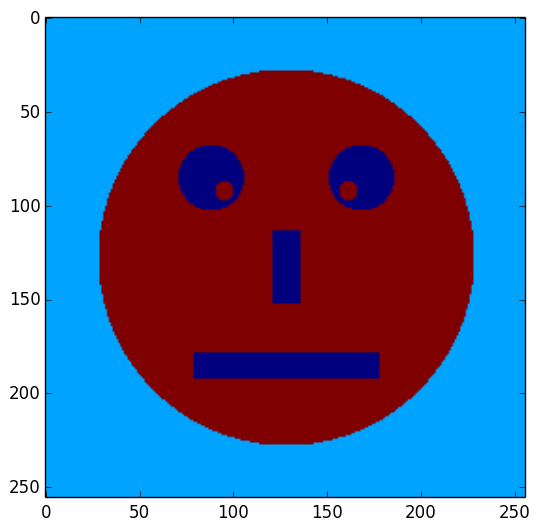

In [5]:
# ion()
fig = figure()
ax = fig[:add_subplot](111)
img = ax[:imshow](kTRANS_map'-kPL_map')
show()

In [6]:
function trajectories(kTRANS::Float64, kPL::Float64)
    # FUNCTION TRAJECTORIES computes trajectories of the model 
    
    N   = 30; 
    x0  = [0.; 0.]; 
    TR  = 2;
    R1P = 1./20; 
    R1L = 1./20;        
    
    gamma = 2.1430
    beta  = 3.4658
    A0    = 10.4105
    t0    = 3.2596
    
    alphas = [30./180*pi*ones(1, N); 30./180*pi*ones(1, N)]
    
    t_input = 2*(1:N);
    u = A0*1000*(max( t_input - t0, zeros(size(t_input)))).^gamma.*exp(-(t_input - t0)/beta);
    
    A = [ -kPL-R1P   0  ;
             kPL   -R1L];  
         
    B = [kTRANS; 0]; 

    C = [1 0; 
         0 1]; 
       
    D = [0; 
         0]; 

    Ad = expm(TR*A)
    Bd = inv(A)*(Ad - eye(2))*B
    
    n = size(Ad, 1); 
    m = size(C, 1); 
    x = zeros(n, N); 
    y = zeros(m, N); 

    # compute state trajectories 
    x[:, 1] = x0; 
    for t=1:N-1
        x[:, t+1] = Ad * diagm(cos(alphas[:, t])) * x[:, t] + Bd * u[t];
    end
    # compute output trajectories 
    for t=1:N
        y[:, t] = C * diagm(sin(alphas[:, t])) * x[:, t] + D * u[t]; 
    end
    
    return y
end

# test trajectories function 
y_sim = trajectories(0.05, 0.07); 

In [7]:
using Gadfly
using Colors 

berkeley_blue = RGB((1/256*[ 45.,  99., 127.])...)
berkeley_gold = RGB((1/256*[224., 158.,  25.])...); 

In [8]:
function generate_simulated_data(Nxy, sigma)
    # Nxy number of samples in each spatial dimension 
    # sigma noise parameter 
    
    # parameters for grid 
    Wx = 25.6;
    Wy = 25.6;
    Nx = Nxy;
    Ny = Nxy;

    # generate space grid
    x_itvl = collect(-Nx/2:Nx/2-1)/Nx * Wx;
    y_itvl = collect(-Ny/2:Ny/2-1)/Ny * Wy;
    
    # generate parameter maps 
    kTRANS_map = generate_kTRANS_map(x_itvl, y_itvl)
    kPL_map    = generate_kPL_map(x_itvl, y_itvl);
    
    dims = size(trajectories(kTRANS_map[1, 1], kPL_map[1, 1]))
    
    return [trajectories(kTRANS_map[i, j], kPL_map[i, j]) + sigma*randn(dims) for i=1:Nx, j=1:Ny]; 
end

simulated_data = generate_simulated_data(32, 1000); 

In [ ]:
y_sim = simulated_data[17, 19]

Gadfly.plot(
    layer(x=2*(0:29), y=y_sim[1, :], Geom.point, Geom.line, Theme(default_color=berkeley_blue)), 
    layer(x=2*(0:29), y=y_sim[2, :], Geom.point, Geom.line, Theme(default_color=berkeley_gold)),
    Guide.XLabel("time from injection start (s)"), 
    Guide.YLabel("signal (au)"), 
)

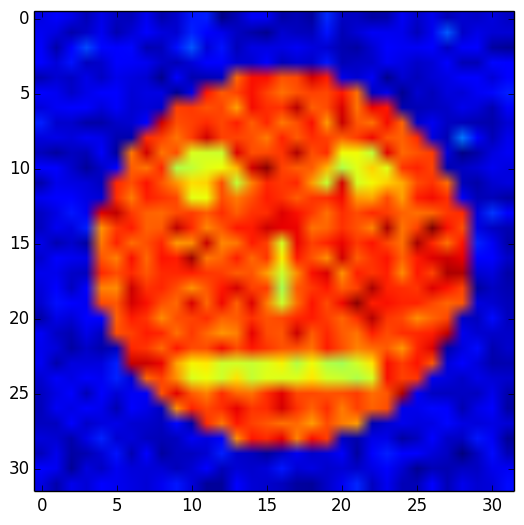

In [9]:
test = [maximum(simulated_data[i, j]) for i=1:32, j=1:32]
fig = figure()
ax = fig[:add_subplot](111)
img = ax[:imshow](test')
show()

In [10]:
using Optim

function least_squares_fit(y_sim)
    function obj(theta::Vector, y::Array{Float64, 2})
        return sum((y - trajectories(theta[1], theta[2])).^2)
    end

    res = optimize(theta->obj(theta, y_sim), [0.05, 0.07])
    return res.minimum
end

least_squares_fit(y_sim)

2-element Array{Float64,1}:
 0.05
 0.07

In [ ]:
# generate simulated data 
simulated_data = generate_simulated_data(32, 2000); 

# compute parameter map 
fit_parameter_map = map(least_squares_fit, simulated_data); 

# extract maps for individual parameters 
fit_kTRANS_map_32 = map(theta->theta[1], fit_parameter_map); 
fit_kPL_map_32    = map(theta->theta[2], fit_parameter_map); 

In [ ]:
# plot kPL map
fig = figure()
ax = fig[:add_subplot](111)
img = ax[:imshow](fit_kPL_map_32')
img[:cmap] = ColorMap("summer")
img[:set_clim](vmin=0, vmax=0.15)
colorbar(img)
title("kPL 32 x 32")
savefig("kPL_32.png")
show()

In [ ]:
# plot kTRANS map
fig = figure()
ax = fig[:add_subplot](111)
img = ax[:imshow](fit_kTRANS_map_32')
img[:cmap] = ColorMap("summer")
img[:set_clim](vmin=0, vmax=0.15)
colorbar(img)
title("kTRANS 32 x 32")
savefig("kTRANS_32.png")
show()

In [ ]:
# generate simulated data 
simulated_data = generate_simulated_data(2*32, 4*1000); 

# compute parameter map 
fit_parameter_map = map(least_squares_fit, simulated_data); 

# extract maps for individual parameters 
fit_kTRANS_map_64 = map(theta->theta[1], fit_parameter_map); 
fit_kPL_map_64    = map(theta->theta[2], fit_parameter_map); 

In [ ]:
# plot kPL map
fig = figure()
ax = fig[:add_subplot](111)
img = ax[:imshow](fit_kPL_map_64')
img[:cmap] = ColorMap("summer")
img[:set_clim](vmin=0, vmax=0.15)
colorbar(img)
title("kPL 64 x 64")
savefig("kPL_64.png")
show()

In [ ]:
# plot kTRANS map
fig = figure()
ax = fig[:add_subplot](111)
img = ax[:imshow](fit_kTRANS_map_64')
img[:cmap] = ColorMap("summer")
img[:set_clim](vmin=0, vmax=0.15)
colorbar(img)
title("kTRANS 64 x 64")
savefig("kTRANS_64.png")
show()

In [ ]:
# generate simulated data 
simulated_data = generate_simulated_data(4*32, 16*1000); 

# compute parameter map 
fit_parameter_map = map(least_squares_fit, simulated_data); 

# extract maps for individual parameters 
fit_kTRANS_map_128 = map(theta->theta[1], fit_parameter_map); 
fit_kPL_map_128    = map(theta->theta[2], fit_parameter_map); 

In [ ]:
# plot kPL map
fig = figure()
ax = fig[:add_subplot](111)
img = ax[:imshow](fit_kPL_map_128')
img[:cmap] = ColorMap("summer")
img[:set_clim](vmin=0, vmax=0.15)
colorbar(img)
title("kPL 128 x 128")
savefig("kPL_128.png")
show()

In [ ]:
# plot kTRANS map
fig = figure()
ax = fig[:add_subplot](111)
img = ax[:imshow](fit_kTRANS_map_128')
img[:cmap] = ColorMap("summer")
img[:set_clim](vmin=0, vmax=0.15)
colorbar(img)
title("kTRANS 128 x 128")
savefig("kTRANS_128.png")
show()

In [18]:
using MATLAB

function ADMM(simulated_data, theta0)
    
    rho = 1e-3
    
    function theta_step(y, theta, z, u)
        
        function obj(theta::Vector, y::Array{Float64, 2})
            return sum((y - trajectories(theta[1], theta[2])).^2) + 0.5*rho*norm(theta - z + u)^2
        end

        res = optimize(theta->obj(theta, y), [0.05, 0.07], xtol=1e-2, iterations=50)
        return res.minimum
    end
    
    # this is the z update for ADMM 
    function prox_g(theta, z, u)
        
        lambda = 1e0
        
        # prox for kTRANS 
        theta1 = map(t->t[1], theta) 
        u1     = map(t->t[1], theta)
        z1     = mxcall(:TV, 1, theta1 + u1, lambda/rho)        
        
        # prox for kPL
        theta2 = map(t->t[2], theta) 
        u2     = map(t->t[2], theta)
        z2     = mxcall(:TV, 1, theta2 + u2, lambda/rho)
        
        # reconstruct z 
        z = map((k1, k2)->[k1, k2], z1, z2)
        
        return z
    end
    
    function u_step(theta, z, u)
        
        return u + theta - z
    end
    
    # initialize ADMM
    theta = map(y->theta0,              simulated_data)
    z     = map(y->theta0,              simulated_data)
    u     = map(y->zeros(size(theta0)), simulated_data)
    
    # iterate ADMM 
    num_iters = 400
    for k=1:num_iters
        theta = map(theta_step, simulated_data, theta, z, u) # this can be parallelized 
        z     = prox_g(theta, z, u)
        u     = map(u_step, theta, z, u) # this can be parallelized too 
        println("====== Iteration ======")
        println(k)
        println(norm(map(x->x[1], theta - z)))
        println(norm(map(x->x[2], theta - z)))
        # println(u)
    end
    theta = map(theta_step, simulated_data, theta, z, u)
    
    return (theta, z, u)
end

fit_parameter_map, z_fit, u_fit = ADMM(simulated_data, [0.05, 0.07])

====== Iteration ======
1
0.4753089294471752
1420.103501458723
====== Iteration ======
2
0.4753090503719883
1171.581835887208
====== Iteration ======
3
0.475308328447593
1067.3548644301322
====== Iteration ======
4
0.4753081323810823
1008.9350587766687
====== Iteration ======
5
0.4753076481797296
987.7521209995227
====== Iteration ======
6
0.475307550993457
970.1514509528316
====== Iteration ======
7
0.4753070755875459
939.9708271843994
====== Iteration ======
8
0.4753073337478484
921.3785757272963
====== Iteration ======
9
0.4753086297961956
899.7091051993573
====== Iteration ======
10
0.47530849828711336
885.7982209784035
====== Iteration ======
11
0.4753078731460048
861.1147862487171
====== Iteration ======
12
0.4753064968355344
844.3491761382126
====== Iteration ======
13
0.475306479837578
834.3659926330121
====== Iteration ======
14
0.47530668401363724
828.9858401856262
====== Iteration ======
15
0.4753085298063481
813.3290988679021
====== Iteration ======
16
0.4753085362522721
80

(
16x16 Array{Array{Float64,1},2}:
 [0.00203382,85.3307]    [-0.000568004,27.5903]    …  [0.00351809,0.102155]  
 [-0.00550779,0.212977]  [-0.00151121,92.0833]        [0.00254923,0.493898]  
 [0.000948056,78.3237]   [-0.00142054,0.0762006]      [0.00133822,0.0965968] 
 [-0.00104657,56.8854]   [-0.000350797,0.629873]      [0.00246656,0.00987968]
 [-0.00174044,0.261113]  [-0.00165668,37.5486]        [0.000231074,50.1735]  
 [0.00249933,100.075]    [-0.000647475,0.220509]   …  [0.00284509,94.1063]   
 [0.00235584,131.437]    [-0.00313609,0.0846633]      [-0.000776612,15.8157] 
 [0.000200623,46.9403]   [-0.001823,-0.0121215]       [-0.000529816,0.42148] 
 [-0.00193268,70.2843]   [-0.00168648,95.0008]        [0.0012667,0.0744579]  
 [0.00192507,0.47097]    [-0.00140691,83.663]         [-0.000554998,0.540478]
 [0.00197908,82.0083]    [-0.00226823,0.313062]    …  [-0.000356033,54.3419] 
 [0.000392567,41.5891]   [0.00193573,60.5519]         [0.0011317,87.6747]    
 [-0.00213499,0.119803]  [-0.

400
0.47531082347971426
391.7413036268999


In [ ]:
    function theta_step(y, theta, z, u)
        
        function obj(theta::Vector, y::Array{Float64, 2})
            return sum((y - trajectories(theta[1], theta[2])).^2) + 0.5*norm(theta - z + u)^2
        end

        res = optimize(theta->obj(theta, y), [0.05, 0.07], xtol=1e-2, iterations=20)
        # return res.minimum
        return res
    end

@time theta_step(simulated_data[1], [0.05, 0.07], [0.05, 0.07], [0.0, 0.0])

In [21]:
# extract maps for individual parameters 
fit_kTRANS_map_ADMM = map(theta->theta[1], fit_parameter_map); 
fit_kPL_map_ADMM    = map(theta->theta[2], fit_parameter_map);

# extract maps for individual parameters 
# fit_kTRANS_map_ADMM = map(theta->theta[1], z_fit); 
# fit_kPL_map_ADMM    = map(theta->theta[2], z_fit);

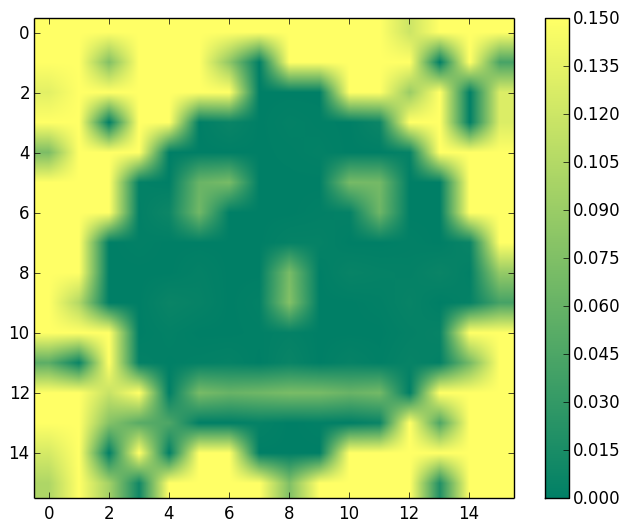

In [22]:
# plot kPL map
fig = figure()
ax = fig[:add_subplot](111)
img = ax[:imshow](fit_kPL_map_ADMM')
img[:cmap] = ColorMap("summer")
img[:set_clim](vmin=0, vmax=0.15)
colorbar(img)
# title("kPL 32 x 32 ADMM")
savefig("kPL_ADMM.png")
show()

In [11]:
simulated_data = generate_simulated_data(16, 1000); 


In [ ]:
fit_parameter_map - z_fit